### Lyric Generator using RNN and Markov chains
#### Chenghui Song
- Markov chains are used to build new sentences (based off of word1=>word2 probabilities)
- Keras.LSTM functions (Recurrent Neural Networks) are used to predict the properties of the next line of the poem (e.g. # syllables, rhyme scheme) such that an appropriate new sentence can be selected (from the setences that were generated with Markovify). 
-  Perform better at making sentences that rhyme as opposed to making sentences that are logical 
-  Best to generate nonsensical rap and hip-hop lyrics

In [1]:
#!pip install pronouncing
#!pip install markovify

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pronouncing
import markovify
import re
import random
import keras
from keras.models import Sequential
from keras.layers import LSTM 
from keras.layers.core import Dense
import os
%matplotlib inline

### Create songlist from the datasets
Data source: https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres?select=lyrics-data.csv
- Two csv datasets are needed:
 - lyrics-data.csv: 
 - artists-data.csv: 

In [3]:
#curr_dir = 'C:\\Users\\cheng\\Downloads\\'
lyrics = pd.read_csv('lyrics-data.csv') 
lyrics=lyrics.query("language=='en'")
artists = pd.read_csv("artists-data.csv")
lyrics_df = pd.merge(lyrics,artists,left_on="ALink",right_on="Link")
lyrics_df = lyrics_df[["Artist","Genres","Popularity","Songs","SName","Lyric"]]
        # Note: Popularity score based on how much each artist/lyric is accessed on the website
lyrics_popular=lyrics_df.query("Songs>500")
lyrics_popular=lyrics_popular.sort_values(['Songs','Artist'], ascending=[False,True])
#lyrics_hop = lyrics_df[lyrics_df["Genres"].str.contains("Hip Hop",na=False)]
print("Shape of songlist from popular artists:",lyrics_popular.shape)
lyrics_popular.head()

Shape of songlist from popular artists: (12330, 6)


,Artist,Genres,Popularity,Songs,SName,Lyric
120727,Frank Sinatra,Jazz; Clássico; Romântico,16.1,828.0,My Way,"And now the end is near,\nAnd so I face the fi..."
120728,Frank Sinatra,Jazz; Clássico; Romântico,16.1,828.0,Fly Me to the Moon,Fly me to the moon\nLet me play among the star...
120729,Frank Sinatra,Jazz; Clássico; Romântico,16.1,828.0,"New York, New York","Start spreading the news,\nI'm leaving today\n..."
120730,Frank Sinatra,Jazz; Clássico; Romântico,16.1,828.0,That's Life,"That's life, that's what all the people say.\n..."
120731,Frank Sinatra,Jazz; Clássico; Romântico,16.1,828.0,Days Of Wine and Roses,<with a jauntier melody than Andy Williams' ve...


### Find the most popular artists by number of songs

In [4]:
# Find list of artists that have > 500 songs in the current dataset
artists = lyrics_popular.reset_index()
artists = artists.drop(columns=['index'])
artists = artists[["Artist","Genres","Popularity","Songs",'SName']]
artists_songs = artists.groupby(['Artist','Genres','Popularity','Songs'])["SName"].count()
list = artists_songs.reset_index()
list=list.drop(columns=['Songs'])
list=list.rename(columns={'SName':'Songs'})
list=list.query("Songs>500")
list=list.reset_index().drop(columns=['index'])
list = list.sort_values(['Songs'],ascending=False).reset_index().drop(columns=['index'])
list

,Artist,Genres,Popularity,Songs
0,Frank Sinatra,Jazz; Clássico; Romântico,16.1,819
1,Elvis Presley,Rockabilly; Romântico; Rock,23.1,747
2,Dolly Parton,Country,1.3,723
3,Matheus Hardke,Pop/Rock,0.1,707
4,Lil Wayne,R&B; Black Music; Rap,4.3,689
5,Glee,Trilha Sonora; Pop/Rock; Pop,3.0,687
6,Hillsong United,Gospel/Religioso; Pop/Rock; Rock,25.8,646
7,Elton John,Soft Rock; Romântico; Pop/Rock,44.7,638
8,Temas de Filmes,COLETÂNEA; Trilha Sonora; Romântico; Instrumental,8.3,628
9,Chris Brown,Rap; Hip Hop; Pop,11.8,623


### Select an artist to generate the lyric corpus

In [5]:
# Collect all lyrics from selected artist
selected_artist = "Bee Gees"
lyrics_artist = lyrics_popular[lyrics_popular.Artist==selected_artist]['Lyric'].values.tolist()
text = ""
for i in range (len(lyrics_artist)):
    text += lyrics_artist[i]+"\n\n"
lines = text.split("\n")
with open("lyrics.txt",'w', encoding="utf-8") as f:
    for line in lines:
        f.write(line)
        f.write("\n")
print('Total number of characters in the corpus ('+selected_artist+') is:',len(text))
print('The first 1000 characters of the corpus are as follows:\n\n',text[:1000])

Total number of characters in the corpus (Bee Gees) is: 564378
The first 1000 characters of the corpus are as follows:

 I know your eyes in the morning sun
I feel you touch me in the pouring rain
And the moment that you wander far from me
I wanna feel you in my arms again

And you come to me on a summer breeze
Keep me warm in your love then you softly leave
And it's me you need to show
How deep is your love

How deep is your love, how deep is your love
I really mean to learn
'Cause we're living in a world of fools
Breaking us down
When they all should let us be
We belong to you and me

I believe in you
And you know the door to my very soul
You're the light in the deepest darkest hour
You're my savior when I fall

And you may not think
That I care for you
When you know down inside that I really do
And it's me you need to show
How deep is your love

How deep is your love, how deep is your love
I really mean to learn
'Cause we're living in a world of fools
Breaking us down
When they all 

### Plot most commonly used words

In [6]:
def plotWordFrequency(input):
    f = open(input,'r', encoding="utf8")
    words = [x for y in [l.split() for l in f.readlines()] for x in y]
    data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40] 
    most_words = [x[0] for x in data]
    times_used = [int(x[1]) for x in data]
    plt.figure(figsize=(20,10))
    plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurences:', fontsize=18)
    plt.title('Most Commonly Used Words', fontsize=24)
    plt.show()

#### Create the RNN layers and Markov Chain

In [7]:
def create_network(depth):
    model = Sequential()
    model.add(LSTM(4, input_shape=(2, 2), return_sequences=True))
    for i in range(depth):
        model.add(LSTM(8, return_sequences=True))
    model.add(LSTM(2, return_sequences=True))
    model.summary()
    model.compile(optimizer='rmsprop',
              loss='mse')
    if artist + ".rap" in os.listdir(".") and train_mode == False:
        model.load_weights(str(artist + ".rap"))
        print("loading saved network: " + str(artist) + ".rap") 
    return model

In [8]:
def markov(text_file):
    ######
    read = open(text_file, "r", encoding='utf-8').read()
    text_model = markovify.NewlineText(read)
    return text_model

#### Determine the rhyme scheme
- Determine number of syllables in line
- Make index of words that rhyme with your word
- Make index of rhymes that you use 

In [9]:
def syllables(line):
    count = 0
    for word in line.split(" "):
        vowels = 'aeiouy'
        # word = word.lower().strip("!@#$%^&*()_+-={}[];:,.<>/?")
        word = word.lower().strip(".:;?!")
        if len(word)>0:
            if word[0] in vowels:
                count +=1
            for index in range(1,len(word)):
                if word[index] in vowels and word[index-1] not in vowels:
                    count +=1
            if word.endswith('e'):
                count -= 1
            if word.endswith('le'):
                count+=1
            if count == 0:
                count +=1
    return count / maxsyllables

In [10]:
def rhymeindex(lyrics):
    if str(artist) + ".rhymes" in os.listdir(".") and train_mode == False:
        print ("loading saved rhymes from " + str(artist) + ".rhymes")
        return open(str(artist) + ".rhymes", "r",encoding='utf-8').read().split("\n")
    else:
        rhyme_master_list = []
        print ("Building list of rhymes:")
        for i in lyrics:
            word = re.sub(r"\W+", '', i.split(" ")[-1]).lower()
            rhymeslist = pronouncing.rhymes(word)
            rhymeslistends = []      
            for i in rhymeslist:
                rhymeslistends.append(i[-2:])
            try:
                rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
            except Exception:
                rhymescheme = word[-2:]
            rhyme_master_list.append(rhymescheme)
        rhyme_master_list = [*set(rhyme_master_list),]
        reverselist = [x[::-1] for x in rhyme_master_list]
        reverselist = sorted(reverselist)
        rhymelist = [x[::-1] for x in reverselist]
        print("List of Sorted 2-Letter Rhyme Ends:")
        print(rhymelist)
        f = open(str(artist) + ".rhymes", "w", encoding='utf-8')
        f.write("\n".join(rhymelist))
        f.close()
        return rhymelist

In [11]:
def rhyme(line, rhyme_list):
    word = re.sub(r"\W+", '', line.split(" ")[-1]).lower()
    rhymeslist = pronouncing.rhymes(word)
    rhymeslistends = []
    for i in rhymeslist:
        rhymeslistends.append(i[-2:])
    try:
        rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
    except Exception:
        rhymescheme = word[-2:]
    try:
        float_rhyme = rhyme_list.index(rhymescheme)
        float_rhyme = float_rhyme / float(len(rhyme_list))
        return float_rhyme
    except Exception:
        float_rhyme = None
    return float_rhyme

#### Separate each line of the input txt

In [12]:
def split_lyrics_file(text_file):
    text = open(text_file, encoding='utf-8').read()
    text = text.split("\n")
    while "" in text:
        text.remove("")
    return text

#### Generate lyrics and build dataset

In [13]:
def generate_lyrics(text_model, text_file):
    bars = []
    last_words = []
    lyriclength = len(open(text_file,encoding='utf-8').read().split("\n"))
    count = 0
    markov_model = markov(text_file)

    while len(bars) < lyriclength / 9 and count < lyriclength * 2:
        bar = markov_model.make_sentence(max_overlap_ratio = .49, tries=100)
        if type(bar) != type(None) and syllables(bar) < 1:
            def get_last_word(bar):
                last_word = bar.split(" ")[-1]
                if last_word[-1] in "!.?,":
                    last_word = last_word[:-1]
                return last_word
            last_word = get_last_word(bar)
            if bar not in bars and last_words.count(last_word) < 3:
                bars.append(bar)
                last_words.append(last_word)
                count += 1
    return bars

In [14]:
def build_dataset(lines, rhyme_list):
    dataset = []
    line_list = []
    for line in lines:
        line_list = [line, syllables(line), rhyme(line, rhyme_list)]
        dataset.append(line_list)
    x_data = []
    y_data = []
    for i in range(len(dataset) - 3):
        line1 = dataset[i    ][1:]
        line2 = dataset[i + 1][1:]
        line3 = dataset[i + 2][1:]
        line4 = dataset[i + 3][1:]
        x = [line1[0], line1[1], line2[0], line2[1]]
        x = np.array(x)
        x = x.reshape(2,2)
        x_data.append(x)
        y = [line3[0], line3[1], line4[0], line4[1]]
        y = np.array(y)
        y = y.reshape(2,2)
        y_data.append(y)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    return x_data, y_data

#### Compose verse

In [15]:
def compose_rap(lines, rhyme_list, lyrics_file, model):
    rap_vectors = []
    human_lyrics = split_lyrics_file(lyrics_file)
    initial_index = random.choice(range(len(human_lyrics) - 1))
    initial_lines = human_lyrics[initial_index:initial_index + 2]
    starting_input = []
    for line in initial_lines:
        starting_input.append([syllables(line), rhyme(line, rhyme_list)])
    starting_vectors = model.predict(np.array([starting_input]).flatten().reshape(1, 2, 2))
    rap_vectors.append(starting_vectors)
    for i in range(100):
        rap_vectors.append(model.predict(np.array([rap_vectors[-1]]).flatten().reshape(1, 2, 2)))
    return rap_vectors

In [16]:
def vectors_into_song(vectors, generated_lyrics, rhyme_list):
    print ("\n\n")	
    print ("Writing verse:")
    print ("\n\n")
    def last_word_compare(rap, line2):
        penalty = 0 
        for line1 in rap:
            word1 = line1.split(" ")[-1]
            word2 = line2.split(" ")[-1]
            while len(word1)>0 and word1[-1] in "?!,. ":
                word1 = word1[:-1]
            while len(word2)>0 and word2[-1] in "?!,. ":
                word2 = word2[:-1]
            if word1 == word2:
                penalty += 0.2
        return penalty
    def calculate_score(vector_half, syllables, rhyme, penalty):
        desired_syllables = vector_half[0]
        desired_rhyme = vector_half[1]
        desired_syllables = desired_syllables * maxsyllables
        desired_rhyme = desired_rhyme * len(rhyme_list)
        score = 1.0 - abs(float(desired_syllables) - float(syllables)) + abs(float(desired_rhyme) - float(rhyme)) - penalty
        return score
    dataset = []
    for line in generated_lyrics:
        line_list = [line, syllables(line), rhyme(line, rhyme_list)]
        dataset.append(line_list)
    rap = []
    vector_halves = []
    for vector in vectors:
        vector_halves.append((vector[0][0]).tolist()) 
        vector_halves.append((vector[0][1]).tolist())
    for vector in vector_halves:
        scorelist = []
        for item in dataset:
            line = item[0]
            if len(rap) != 0:
                penalty = last_word_compare(rap, line)
            else:
                penalty = 0
            total_score = calculate_score(vector, item[1], item[2], penalty)
            score_entry = [line, total_score]
            scorelist.append(score_entry)
        fixed_score_list = [0]
        for score in scorelist:
            fixed_score_list.append(float(score[1]))
        max_score = max(fixed_score_list)
        for item in scorelist:
            if item[1] == max_score:
                rap.append(item[0])
                print (str(item[0]))
                for i in dataset:
                    if item[0] == i[0]:
                        dataset.remove(i)
                        break
                break     
    return rap

#### Train and run the model

In [17]:
def train(x_data, y_data, model):
    model.fit(np.array(x_data), np.array(y_data),
              batch_size=2,
              epochs=5,
              verbose=1)
    model.save_weights(artist + ".rap")

In [18]:
def main(depth, train_mode):
    model = create_network(depth)
    text_model = markov(text_file)
    if train_mode == True:
        bars = split_lyrics_file(text_file)
    if train_mode == False:
        bars = generate_lyrics(text_model, text_file)
    rhyme_list = rhymeindex(bars)
    if train_mode == True:
        x_data, y_data = build_dataset(bars, rhyme_list)
        train(x_data, y_data, model)
    if train_mode == False:
        vectors = compose_rap(bars, rhyme_list, text_file, model)
        rap = vectors_into_song(vectors, bars, rhyme_list)
        f = open(rap_file, "w", encoding='utf-8')
        for bar in rap:
            f.write(bar)
            f.write("\n")

#### Important parameters
1. maxsyllables: max # of syllables per line; 
2. max_overlap_ratio: how different the output should be from the original input; 
3. tries: how many times to try to build a line that satisifies some parameter; 
4. epochs: how many times for the NN to pass over the data.

To reduce computational complexity, maximize (1) and (2) and minimize (3) and (4).
Computational time will increase dramatically when (1) is less than 8 and when (2) is less than 0.5

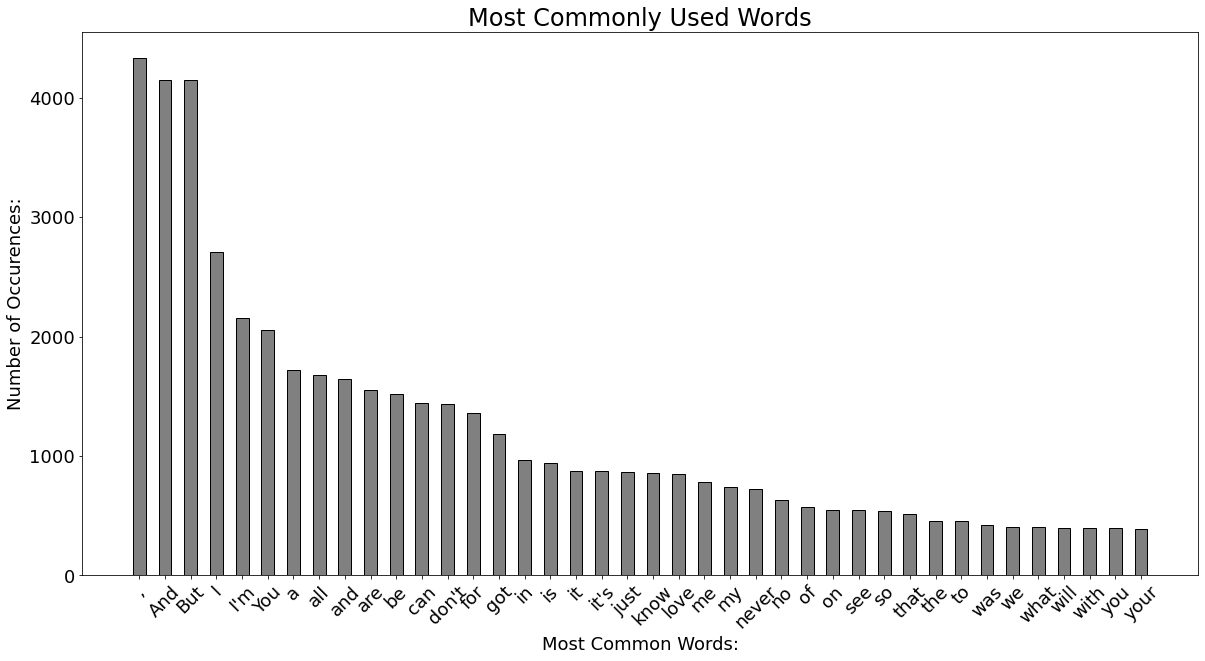

In [19]:
depth = 4 
maxsyllables = 8
text_file = "lyrics.txt"
artist = "artist"
rap_file = "temporary_lyrics.txt"
plotWordFrequency(text_file)

In [20]:
train_mode = True        
main(depth, train_mode)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 4)              112       
                                                                 
 lstm_1 (LSTM)               (None, 2, 8)              416       
                                                                 
 lstm_2 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_3 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_4 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_5 (LSTM)               (None, 2, 2)              88        
                                                                 
Total params: 2,248
Trainable params: 2,248
Non-trainabl

In [21]:
train_mode = False
main(depth, train_mode)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 4)              112       
                                                                 
 lstm_7 (LSTM)               (None, 2, 8)              416       
                                                                 
 lstm_8 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_9 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_10 (LSTM)              (None, 2, 8)              544       
                                                                 
 lstm_11 (LSTM)              (None, 2, 2)              88        
                                                                 
Total params: 2,248
Trainable params: 2,248
Non-traina

### References:
https://www.kaggle.com/code/paultimothymooney/poetry-generator-rnn-markov